In [364]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import arviz as az
import seaborn as sns
from pathlib import Path
from scipy.stats import halfnorm
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

Note: based on the class notebook "3-Bayesian-t-test.ipynb"

In [365]:
df = load_data(r"D:\misc\code\bayesian_retry\data_hockey")
df = df.loc[df.Resultat != " -:-"]
df = df.loc[df.Resultat != " 0:0"]
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,Id,Liga,Region,Phase,TV/Online
0,Mi,09.09.2015,19:45,ZSC Lions,SC Bern,5:3,1:0|2:3|2:0,NaN,Ende,False,"Hallenstadion AG, Zürich",9038,20161105071114,NL A,CH,Regular Season,NaN
1,Fr,11.09.2015,19:45,SC Bern,SCL Tigers,7:1,1:0|4:1|2:0,NaN,Ende,False,"PostFinance-Arena, Bern",17031,20161105071001,NL A,CH,Regular Season,NaN
2,Fr,11.09.2015,19:45,HC Davos,Fribourg-Gottéron,4:5,1:0|1:3|2:1|0:1,SO,Ende,False,"Vaillant Arena, Davos",4488,20161105071002,NL A,CH,Regular Season,NaN
3,Fr,11.09.2015,19:45,Genève-Servette HC,HC Ambri-Piotta,8:2,1:2|4:0|3:0,NaN,Ende,False,"Les Vernets, Genève",5804,20161105071003,NL A,CH,Regular Season,NaN
4,Fr,11.09.2015,19:45,EHC Kloten,EHC Biel-Bienne,3:7,2:1|0:3|1:3,NaN,Ende,False,"SWISS Arena, Kloten",4152,20161105071004,NL A,CH,Regular Season,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,Sa,23.04.2022,20:00,EV Zug,ZSC Lions,1:2,1:0|0:0|0:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000413,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2454,Mo,25.04.2022,20:00,ZSC Lions,EV Zug,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000414,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2455,Mi,27.04.2022,20:00,EV Zug,ZSC Lions,4:1,0:0|1:1|3:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000415,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2456,Fr,29.04.2022,20:00,ZSC Lions,EV Zug,0:2,0:1|0:0|0:1,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000416,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"


In [366]:
df.Resultat.unique()

array([' 5:3', ' 7:1', ' 4:5', ' 8:2', ' 3:7', ' 2:5', ' 1:0', ' 3:2',
       ' 6:3', ' 2:3', ' 3:4', ' 1:4', ' 2:4', ' 4:2', ' 3:1', ' 4:3',
       ' 1:2', ' 1:3', ' 5:1', ' 4:6', ' 3:0', ' 0:5', ' 2:0', ' 5:0',
       ' 6:1', ' 2:1', ' 0:4', ' 0:2', ' 4:1', ' 5:4', ' 5:2', ' 1:6',
       ' 4:0', ' 3:5', ' 2:6', ' 6:0', ' 7:0', ' 0:6', ' 3:6', ' 0:1',
       ' 5:6', ' 7:4', ' 1:5', ' 7:5', ' 1:9', ' 7:2', ' 0:3', ' 6:5',
       ' 4:7', ' 0:7', ' 6:2', ' 6:4', ' 9:4', ' 8:1', ' 1:8', ' 8:3',
       ' 1:7', ' 9:2', ' 8:4', ' 7:3', ' 2:7', ' 9:3', ' 10:3', ' 8:5',
       ' 6:9', ' 5:7', ' 7:6', ' 6:7', ' 4:9', ' 3:9', ' 3:8', ' 4:10',
       ' 8:0', ' 4:8', ' 8:7', ' 11:0'], dtype=object)

# Preprocessing and data exploration

In [367]:
# create a dictionary to store the points for each team
points_dict = {}
hcl_home = []
hcl_away = []

home = []
away = []

# iterate over each row in the dataframe
for index, row in df.iterrows():
    # extract the team names
    home_team = row['Home']
    away_team = row['Away']
    
    # extract the result for the home and away team
    home_result = row['Resultat'].split(':')[0].strip()
    away_result = row['Resultat'].split(':')[1].strip()
    
    # add points to the home team
    if home_team not in points_dict:
        points_dict[home_team] = {'total': 0, 'home': 0, 'away': 0}
    # add to total points column
    points_dict[home_team]['total'] += int(home_result)
    points_dict[home_team]['home'] += int(home_result)

    # add to list of hcl points
    if home_team == 'HC Lugano':
        hcl_home.append(home_result)
    home.append(home_result)
    # add to specific team column
    points_dict[home_team][away_team + ' (away)'] = points_dict[home_team].get(away_team + ' (away)', 0) + int(away_result)
    
    # add points to the away team
    if away_team not in points_dict:
        points_dict[away_team] = {'total': 0, 'home': 0, 'away': 0}
    points_dict[away_team]['total'] += int(away_result)
    points_dict[away_team]['away'] += int(away_result)

    # add to list of hcl points
    if away_team == 'HC Lugano':
        hcl_away.append(away_result)
    away.append(away_result)
    points_dict[away_team][home_team + ' (home)'] = points_dict[away_team].get(home_team + ' (home)', 0) + int(home_result)

# create a new dataframe from the points_dict
points_df = pd.DataFrame.from_dict(points_dict, orient='index')

In [368]:
points_df

,total,home,away,SC Bern (away),Lausanne HC (away),HC Ambri-Piotta (home),EHC Biel-Bienne (home),Fribourg-Gottéron (away),SCL Tigers (home),EHC Kloten (away),...,EV Zug (away),HC Davos (home),SC Rapperswil-Jona Lakers (home),SC Rapperswil-Jona Lakers (away),HC Ajoie (away),HC Ajoie (home),ZSC Lions (home),ZSC Lions (away),SC Langenthal (away),SC Langenthal (home)
ZSC Lions,1258,668,590,63.0,26.0,32.0,60.0,37.0,42.0,23.0,...,55.0,46.0,31.0,21.0,4.0,8.0,NaN,NaN,NaN,NaN
SC Bern,1223,656,567,NaN,49.0,36.0,64.0,42.0,42.0,21.0,...,50.0,55.0,22.0,15.0,1.0,3.0,54.0,57.0,NaN,NaN
SCL Tigers,954,488,466,45.0,54.0,55.0,66.0,33.0,NaN,32.0,...,57.0,58.0,29.0,26.0,5.0,5.0,74.0,76.0,NaN,NaN
HC Davos,1212,624,588,52.0,46.0,60.0,54.0,39.0,35.0,19.0,...,67.0,NaN,47.0,42.0,0.0,6.0,57.0,48.0,NaN,NaN
Fribourg-Gottéron,1086,604,482,50.0,50.0,56.0,42.0,NaN,34.0,17.0,...,49.0,50.0,33.0,19.0,4.0,1.0,56.0,44.0,NaN,NaN
Genève-Servette HC,1118,606,512,57.0,48.0,34.0,67.0,46.0,30.0,16.0,...,47.0,26.0,20.0,14.0,5.0,7.0,44.0,37.0,NaN,NaN
HC Ambri-Piotta,992,536,456,43.0,44.0,NaN,68.0,35.0,45.0,27.0,...,59.0,62.0,33.0,30.0,2.0,5.0,51.0,42.0,3.0,1.0
EHC Kloten,471,248,223,16.0,28.0,34.0,18.0,21.0,32.0,NaN,...,24.0,30.0,6.0,11.0,NaN,NaN,23.0,30.0,NaN,NaN
EHC Biel-Bienne,1151,631,520,64.0,42.0,48.0,NaN,51.0,56.0,19.0,...,43.0,66.0,28.0,12.0,1.0,2.0,59.0,62.0,NaN,NaN
HC Lugano,1233,691,542,43.0,40.0,53.0,71.0,42.0,40.0,18.0,...,84.0,59.0,31.0,28.0,2.0,5.0,77.0,45.0,NaN,NaN


In [369]:
# select HC Lugano, HC Ambri-Piotta for our first hypotheses test.
df_1 = points_df[points_df.index.isin(['HC Lugano', 'HC Ambri-Piotta'])]
df_1

,total,home,away,SC Bern (away),Lausanne HC (away),HC Ambri-Piotta (home),EHC Biel-Bienne (home),Fribourg-Gottéron (away),SCL Tigers (home),EHC Kloten (away),...,EV Zug (away),HC Davos (home),SC Rapperswil-Jona Lakers (home),SC Rapperswil-Jona Lakers (away),HC Ajoie (away),HC Ajoie (home),ZSC Lions (home),ZSC Lions (away),SC Langenthal (away),SC Langenthal (home)
HC Ambri-Piotta,992,536,456,43.0,44.0,NaN,68.0,35.0,45.0,27.0,...,59.0,62.0,33.0,30.0,2.0,5.0,51.0,42.0,3.0,1.0
HC Lugano,1233,691,542,43.0,40.0,53.0,71.0,42.0,40.0,18.0,...,84.0,59.0,31.0,28.0,2.0,5.0,77.0,45.0,NaN,NaN


# Hypothesis test 1
We want to compare if HC Lugano scores more goals while playing at home or away.

In [370]:
# cast to float numpy arrays for pymc3
points_home = df_1.iloc[0, 3:].values
points_away = df_1.iloc[1, 3:].values
points_home = np.array(points_home, dtype=float)
points_away = np.array(points_away, dtype=float)

In [371]:
hcl_home, hcl_away = np.array(sorted(hcl_home), dtype=float), np.array(sorted(hcl_away), dtype=float)
home, away = np.array(sorted(home), dtype=float), np.array(sorted(away), dtype=float)

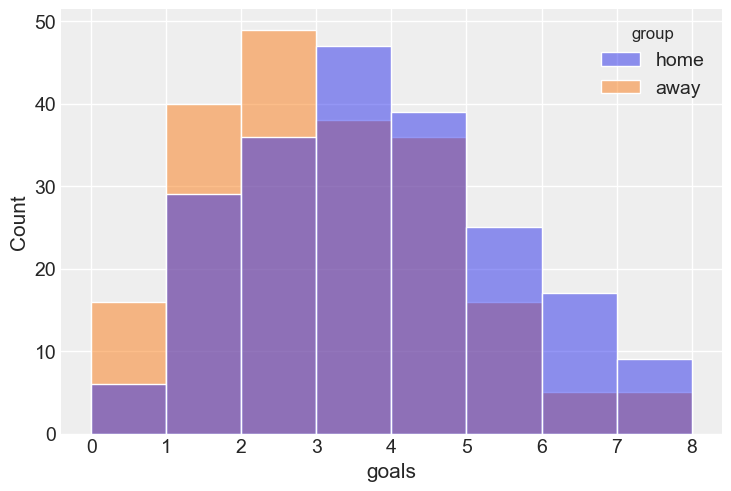

In [372]:
y  = pd.DataFrame(dict(goals=np.r_[hcl_home, hcl_away], group=np.r_[["home"]*len(hcl_home), ['away']*len(hcl_away)]))
sns.histplot(data=y, x="goals", hue="group", bins=8);

In [373]:
print(f"Sample mean goals at home: {np.mean(hcl_home):.3f}")
print(f"Sample mean goals away: {np.mean(hcl_away):.3f}")

Sample mean goals at home: 3.322
Sample mean goals away: 2.644


# Research question
From the distributions we see that when the game is played at home the mean goals are higher.

We want to test if this is true:
* Are the expected goals for the home team higher than the ones away?

We assume the distribution is Normal.

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_{home}$, $\bar{y}_{away}$) 

    * sample standard deviations ($s_{home}, s_{away}$) 

    * numerosity ($n_{home}, n_{away}$)


* The sample are drawn from two populations with unknown parameters $\mu_{home}, \mu_{away}, \sigma_{home}, \sigma_{away}$.

# Background information to set the prior
From a research we found the mean goals per game is 7.2. Given this we can divide the score between the two teams, resulting in a mean of 3.6 goals per team in one game.

Extreme values of goals are 0 and 8. A plausible value of standard deviation in the population is thus   (3.6 - 0)/2 = 1.8.

# Prior for $\mu_{\text{home}}$ and $\mu_{\text{away}}$

* The  mean goals of the population lies in (1.8, 5.4);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{home}}   \sim  N (3.6, 1.8)
$$
$$
\mu_{\text{away}}   \sim  N (3.6, 1.8)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



In [374]:
# Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 1.8
# this yields a diffuse prior, but still defined over plausible range.
pd.DataFrame(halfnorm.rvs(scale=3, size=10000)).describe()

,0
count,10000.000000
mean,2.408994
std,1.814548
min,0.000498
25%,0.980877
50%,2.040138
75%,3.451943
max,11.478192


# The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{home}} & \sim N(3.6,1.8) \\
\sigma_{\text{home}} & \sim \text{half-normal} (3) \\
\vec{y}_{\text{home}}  & \sim N(\mu_{\text{home}}, \sigma_{\text{home}}) \\
\\
\mu_{\text{away}} & \sim N(3.6,1.8) \\
\sigma_{\text{away}} & \sim \text{half-normal} (3) \\
\vec{y}_{\text{away}}  & \sim N(\mu_{\text{away}}, \sigma_{\text{away}})\\
\end{align*}

## Comparing two means $\mu_{home}$ and $\mu_{away}$

We consider  the difference between the means of the populations:
$$\mu_{home} - \mu_{away}$$

* We will have the posterior samples of ($\mu_{home} - \mu_{away}$) in the trace.

In [375]:
with pm.Model() as normal_model:
    # priors
    mu_home = pm.Normal('mu_home', mu=3.6, sd=1.8)
    mu_away = pm.Normal('mu_away', mu=3.6, sd=1.8)
    sigma_home = pm.HalfNormal('sigma_home', sigma=3)
    sigma_away = pm.HalfNormal('sigma_away', sigma=3)

    # likelihood of home games
    y_home = pm.Normal('y_home',  mu=mu_home, sigma=sigma_home, observed = hcl_home)

    # likelihood of away games
    y_away = pm.Normal('y_away', mu=mu_away, sigma=sigma_away, observed = hcl_away)

    # deterministic variable of interest
    diff_of_means = pm.Deterministic('diff_of_means', mu_home - mu_away)

In [376]:
with normal_model:
    normal_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_away, sigma_home, mu_away, mu_home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


## Checking convergence

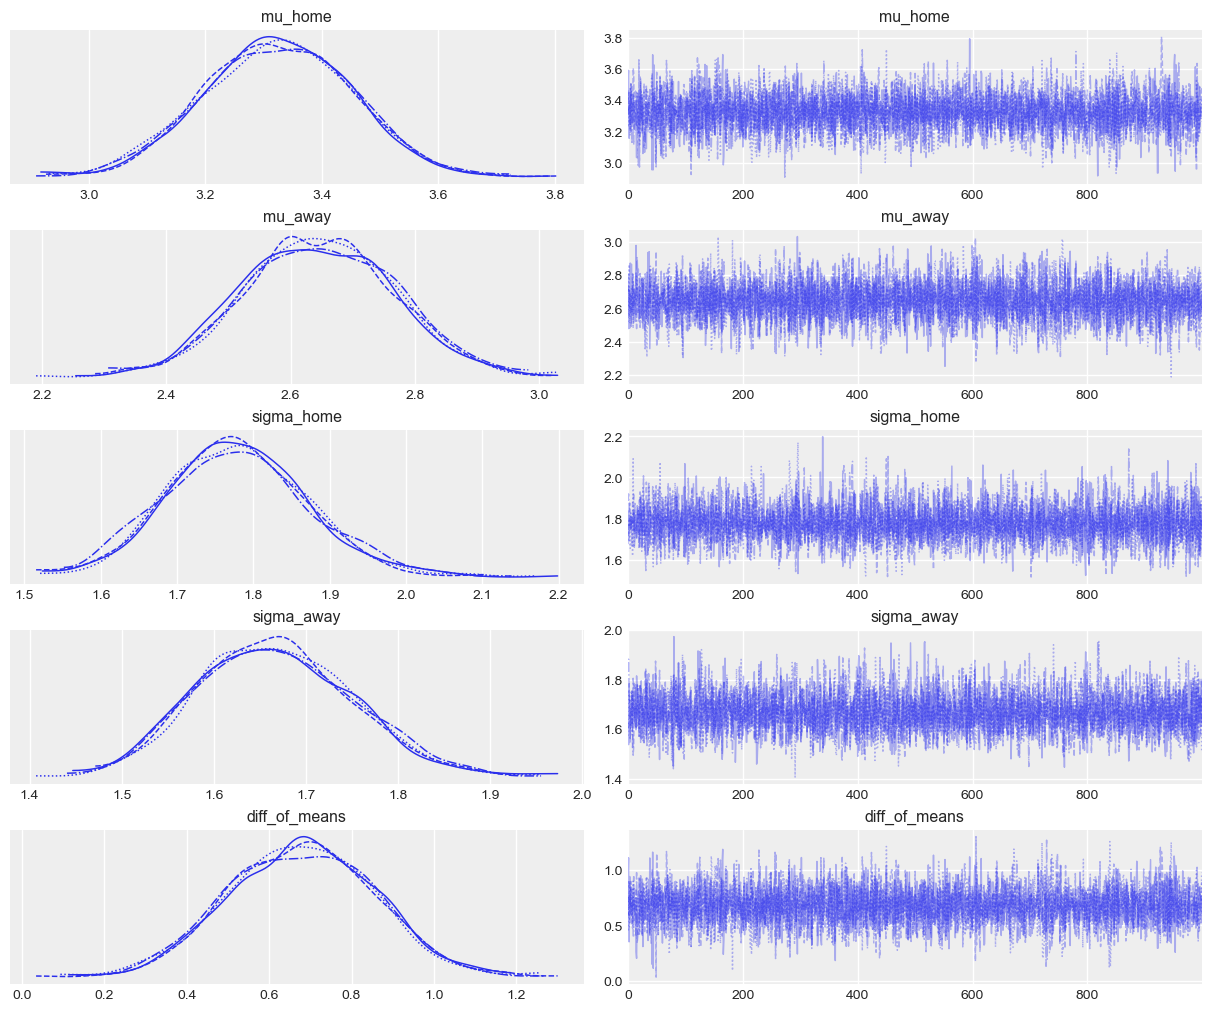

In [377]:
az.plot_trace(normal_trace);

The model converges good.

## Answering the questions

In [378]:
# The posterior distribution can be checked in different ways, depending on the question we want to answer.

# question 1: is the hypothesis of equal means of the two populations plausible?
az.summary(normal_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_home,3.324,0.126,3.073,3.556,0.002,0.001,5955.0,3182.0,1.0
mu_away,2.646,0.120,2.425,2.888,0.001,0.001,6781.0,3150.0,1.0
sigma_home,1.779,0.093,1.598,1.958,0.001,0.001,7136.0,2742.0,1.0
sigma_away,1.667,0.083,1.512,1.828,0.001,0.001,7035.0,3277.0,1.0
diff_of_means,0.678,0.175,0.340,1.015,0.002,0.002,6460.0,2886.0,1.0


The 95% HDI interval does not include the value 0. When an interval excludes 0, it means that the observed difference between the means is unlikely to be due to random chance alone, and is more likely to reflect a true difference between the populations they represent. Therefore, we can confidently conclude that the means are indeed different, and we reject the null hypothesis that they are equal.

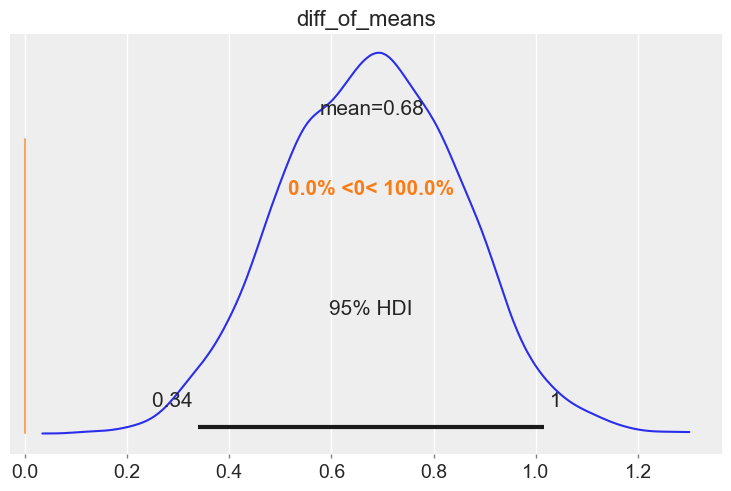

In [379]:
# question 2: which is the posterior probability of a positive effect?
az.plot_posterior(normal_trace, var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

The probability of the team scoring more goal while playing at home rather than away is 100%.

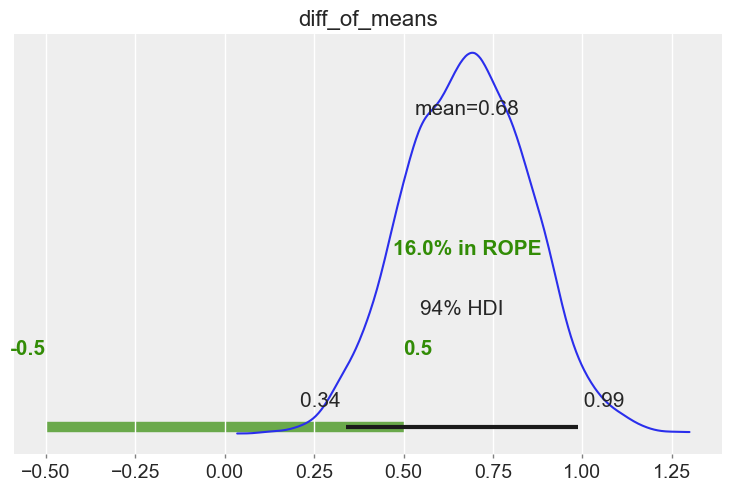

In [397]:
az.plot_posterior(normal_trace,  var_names="diff_of_means", rope=(-0.5, 0.5));

We classify a large difference as making more than 3 points more on average, a medium difference with scoring at least 1 goal and not more than 3, less than a goal we consider to be a small difference.

In [390]:
samples = az.extract_dataset(normal_trace,)
diff_samples = samples.diff_of_means.values
p_significant_large = ((diff_samples > 3).sum() ) / len(diff_samples)
p_significant_medium = (np.logical_and(diff_samples > 1, diff_samples < 3).sum()) / len(diff_samples)
p_significant_small = 1 -  p_significant_medium  -  p_significant_large

print(f"p(large point difference) = {p_significant_large:.3f}")
print(f"p(medium point difference) = {p_significant_medium:.3f}")
print(f"p(small point difference): = {p_significant_small:.3f}")

p(large point difference) = 0.000
p(medium point difference) = 0.031
p(small point difference): = 0.969


From the tests we conclude that we can expect to see the home team to win rather than the away one.

## Posterior predictive checks

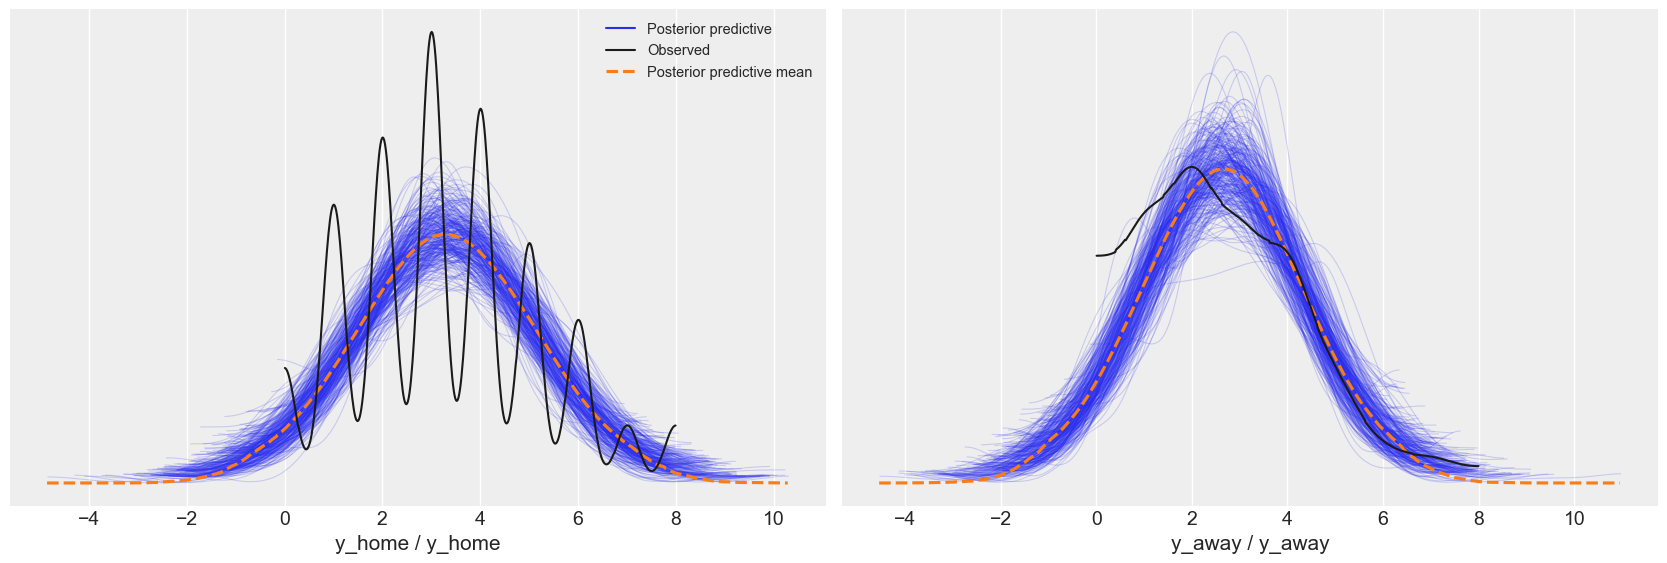

In [411]:
with normal_model:
     ppc = pm.sample_posterior_predictive(normal_trace, samples=300)

# the density is too low in the bulk of the distribution, for the first group
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=normal_model));

# Prior sensitivity

In [401]:
with pm.Model() as normal_model_sensitivity:
    # priors
    # check uninformative priors with a large range.
    mu_home = pm.Uniform('mu_home', lower=0, upper=40)
    mu_away = pm.Uniform('mu_away', lower=0, upper=40)
    # model heavier tails with the half cauchy
    sigma_home = pm.HalfCauchy('sigma_home', beta=3)
    sigma_away = pm.HalfCauchy('sigma_away', beta=3)

    # likelihood of player home 
    y_home = pm.Normal('y_home',  mu=mu_home, sigma=sigma_home, observed= hcl_home)

    # likelihood of player away
    y_away = pm.Normal('y_lj', mu=mu_away, sigma=sigma_away, observed= hcl_away)

    # deterministic variable of interest
    diff_of_means = pm.Deterministic('diff_of_means', mu_home - mu_away)

In [402]:
# sample
with normal_model_sensitivity:
    normal_sensitivity_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_away, sigma_home, mu_away, mu_home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


## Convergence for the alternative priors

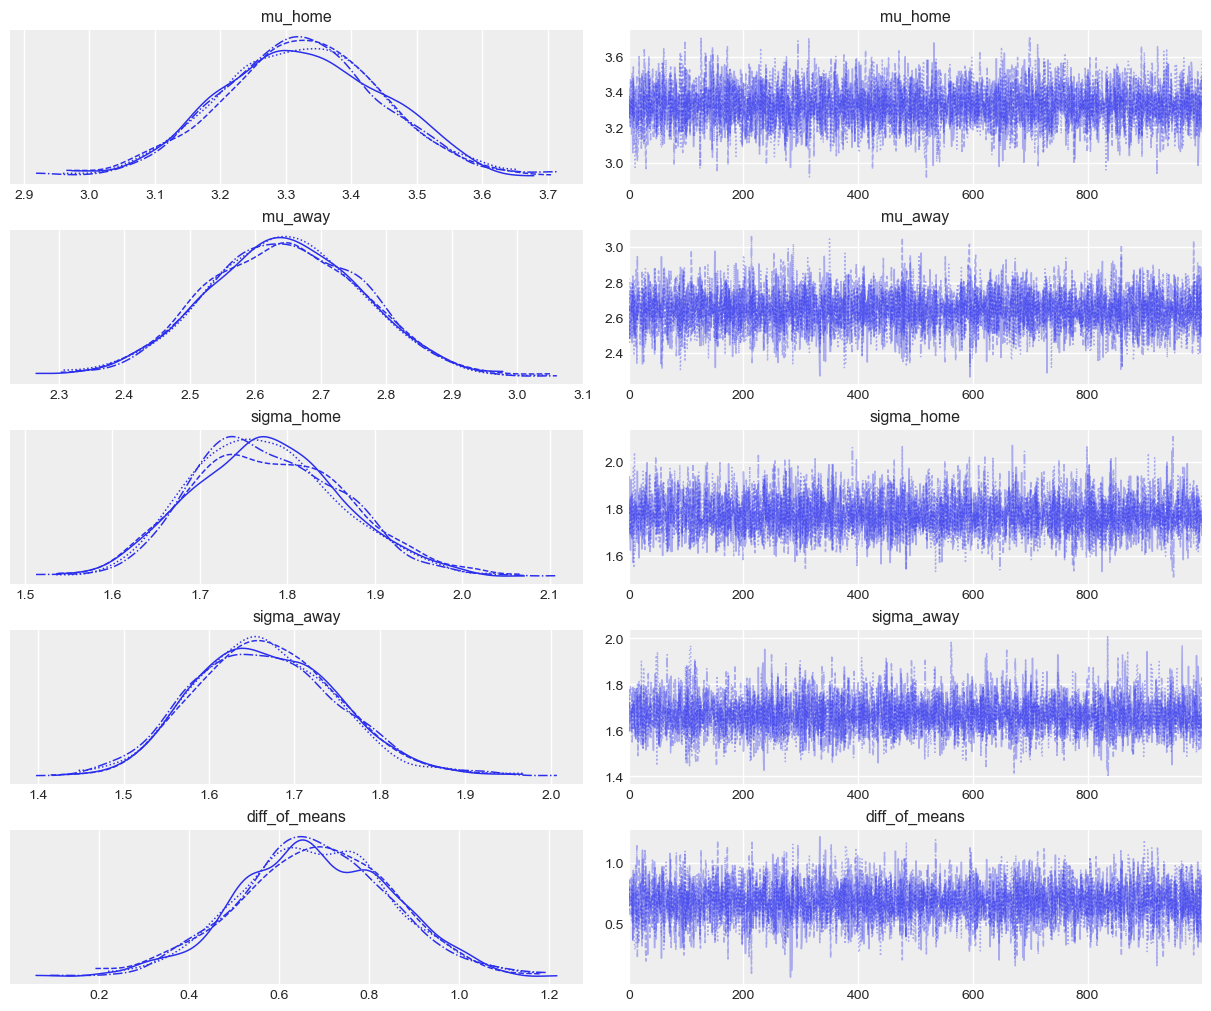

In [403]:
az.plot_trace(normal_sensitivity_trace);

## Updated results

In [404]:
az.summary(normal_sensitivity_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_home,3.324,0.122,3.071,3.545,0.002,0.001,5677.0,2916.0,1.0
mu_away,2.644,0.118,2.419,2.874,0.001,0.001,7602.0,3005.0,1.0
sigma_home,1.777,0.085,1.622,1.947,0.001,0.001,6351.0,3031.0,1.0
sigma_away,1.667,0.084,1.502,1.828,0.001,0.001,6647.0,2971.0,1.0
diff_of_means,0.680,0.169,0.332,0.995,0.002,0.002,6369.0,3277.0,1.0


As before 0 is not included, therefore we reject once again the null hypothesis of the means being equal.

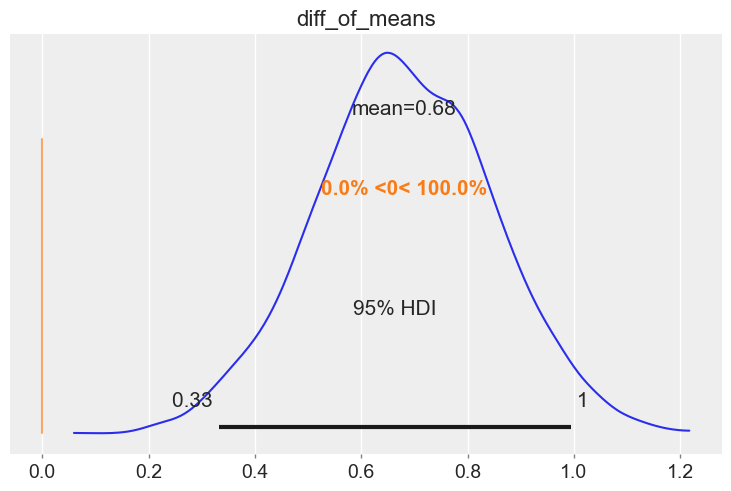

In [405]:
az.plot_posterior(normal_sensitivity_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

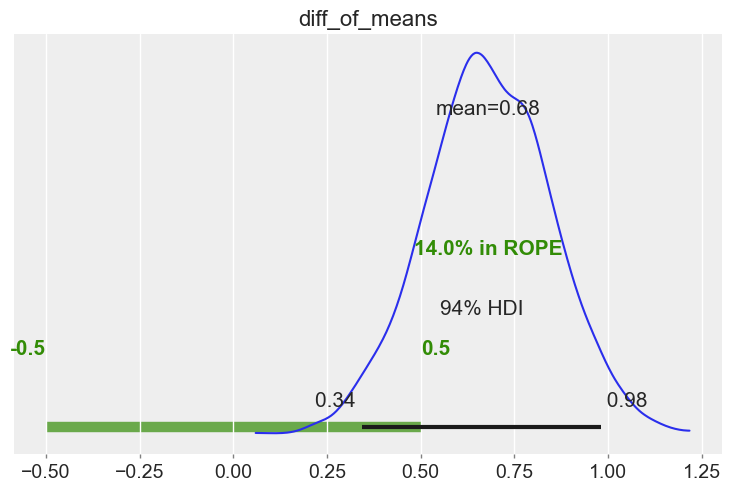

In [407]:
az.plot_posterior(normal_sensitivity_trace,  var_names="diff_of_means", rope=(-0.5, 0.5));

In [409]:
samples = az.extract_dataset(normal_sensitivity_trace,)
diff_samples = samples.diff_of_means.values
p_significant_large = ((diff_samples > 3).sum() ) / len(diff_samples)
p_significant_medium = (np.logical_and(diff_samples > 1, diff_samples < 3).sum()) / len(diff_samples)
p_significant_small = 1 -  p_significant_medium  -  p_significant_large

print(f"p(large point difference) = {p_significant_large:.3f}")
print(f"p(medium point difference) = {p_significant_medium:.3f}")
print(f"p(small point difference): = {p_significant_small:.3f}")

p(large point difference) = 0.000
p(medium point difference) = 0.029
p(small point difference): = 0.971


## Predictive check

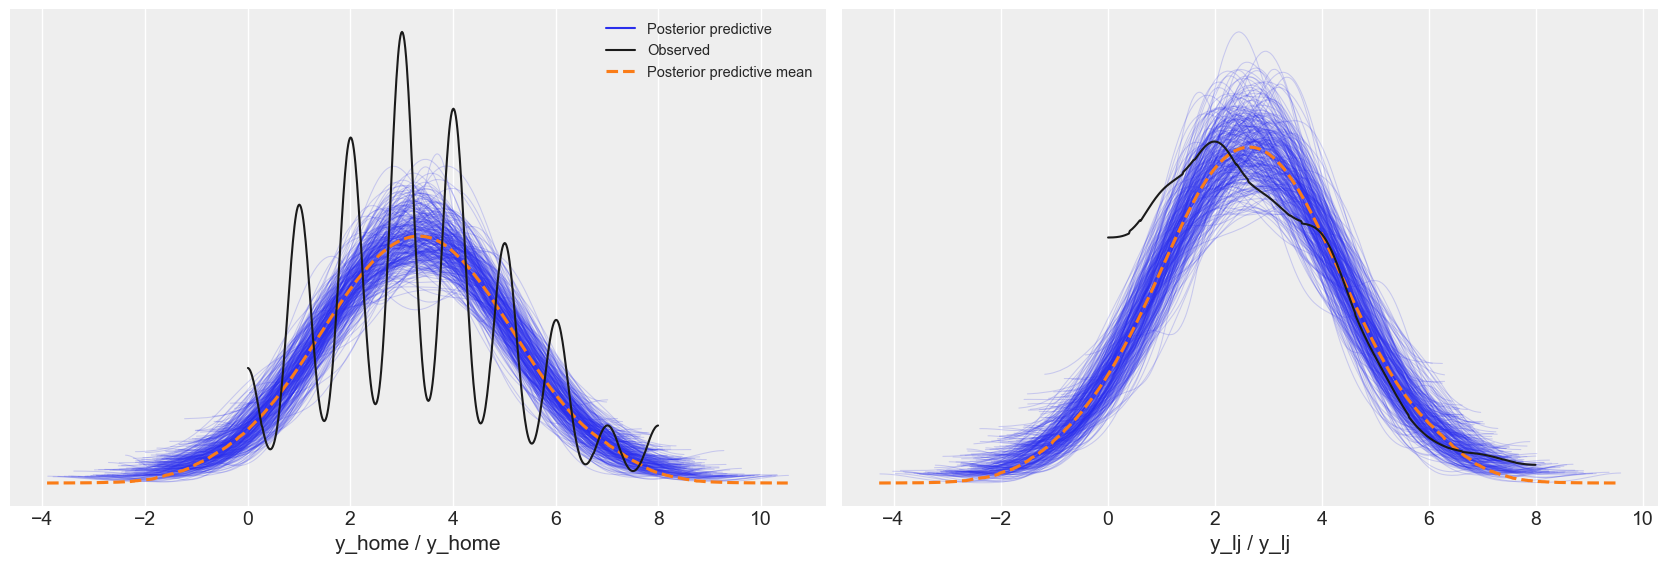

In [410]:
with normal_model_sensitivity:
     ppc = pm.sample_posterior_predictive(normal_sensitivity_trace, samples=300)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=normal_model_sensitivity));

# Hypothesis 2